In [42]:
import requests
from urllib.request import urlopen
from io import StringIO
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

from pyproj import CRS, Transformer
import json

sns.set_theme()
%matplotlib inline  
plt.rcParams["figure.figsize"] = (12,6)

# Data Collection

In [17]:
# fetch bicycle theft data from police
req = requests.get(
    "https://www.internetwache-polizei-berlin.de/vdb/Fahrraddiebstahl.csv"
)

# # write data to csv file
# csv_file = open("fahrraddiebstaehle.csv", "w", encoding="utf-8")
# csv_file.write(req.text)
# csv_file.close()

# load data to pandas df
df = pd.read_csv(StringIO(req.text), delimiter=",", dtype={"LOR": object})

In [18]:
# fetch LOR data to connect Planungsraum-Nummer with Name and other LOR levels
response = urlopen("https://raw.githubusercontent.com/JJestel/HCDS/main/a1/data/lor.csv")
lor = pd.read_csv(response, delimiter=";", dtype=object)

# fetch population data per Planungsraum
response = urlopen("https://raw.githubusercontent.com/JJestel/HCDS/main/a1/data/einwohnerbestand_06-2022_plr.csv")
ew = pd.read_csv(response, delimiter=";", dtype={"PLR-ID": object})

# fetch geojson of Planungsräume for choropleth
response = requests.get("https://tsb-opendata.s3.eu-central-1.amazonaws.com/lor_planungsgraeume_2021/lor_planungsraeume_2021.geojson")
geojson = json.loads(response.content)

# Data Processing

In [19]:
# combine TATZEIT columns and change format
df['TATZEIT_ANFANG'] = pd.to_datetime(df['TATZEIT_ANFANG_DATUM'].astype(str) + ' ' + df['TATZEIT_ANFANG_STUNDE'].astype(str) + ':00:00', dayfirst=True)
df['TATZEIT_ENDE'] = pd.to_datetime(df['TATZEIT_ENDE_DATUM'].astype(str) + ' ' + df['TATZEIT_ENDE_STUNDE'].astype(str) + ':00:00', dayfirst=True)
df = df.drop(columns=['TATZEIT_ANFANG_DATUM', 'TATZEIT_ANFANG_STUNDE', 'TATZEIT_ENDE_DATUM', 'TATZEIT_ENDE_STUNDE'])
df['ANGELEGT_AM'] = pd.to_datetime(df['ANGELEGT_AM'], dayfirst=True)
df

,ANGELEGT_AM,LOR,SCHADENSHOEHE,VERSUCH,ART_DES_FAHRRADS,DELIKT,ERFASSUNGSGRUND,TATZEIT_ANFANG,TATZEIT_ENDE
0,2023-05-10,05200630,1200,Nein,Herrenfahrrad,Fahrraddiebstahl,Sonstiger schwerer Diebstahl von Fahrrädern,2023-05-05 20:00:00,2023-05-05 21:00:00
1,2023-05-10,08100105,219,Nein,Damenfahrrad,Fahrraddiebstahl,Sonstiger schwerer Diebstahl von Fahrrädern,2023-05-08 06:00:00,2023-05-09 14:00:00
2,2023-05-10,01401047,1599,Nein,Herrenfahrrad,Fahrraddiebstahl,Sonstiger schwerer Diebstahl von Fahrrädern,2023-05-10 11:00:00,2023-05-10 13:00:00
3,2023-05-10,02200211,374,Nein,Damenfahrrad,Fahrraddiebstahl,Sonstiger schwerer Diebstahl von Fahrrädern,2023-05-08 23:00:00,2023-05-09 18:00:00
4,2023-05-10,08100104,1000,Nein,Herrenfahrrad,Fahrraddiebstahl,Sonstiger schwerer Diebstahl von Fahrrädern,2023-05-09 18:00:00,2023-05-10 15:00:00
...,...,...,...,...,...,...,...,...,...
28856,2022-01-02,07200413,660,Nein,Damenfahrrad,Fahrraddiebstahl,Sonstiger schwerer Diebstahl von Fahrrädern,2022-01-02 08:00:00,2022-01-02 17:00:00
28857,2022-01-01,01300730,150,Nein,Herrenfahrrad,Fahrraddiebstahl,Sonstiger schwerer Diebstahl von Fahrrädern,2022-01-01 20:00:00,2022-01-01 20:00:00
28858,2022-01-01,02100106,190,Nein,Herrenfahrrad,Fahrraddiebstahl,Sonstiger schwerer Diebstahl von Fahrrädern,2022-01-01 04:00:00,2022-01-01 08:00:00
28859,2022-01-01,03601142,1000,Nein,Herrenfahrrad,Fahrraddiebstahl,Einfacher Diebstahl von Fahrrädern,2022-01-01 14:00:00,2022-01-01 14:00:00


In [20]:
# merge population and lor data (Lebensweltlich orientierte Räume Berlin) 
lor = lor.merge(ew, left_on='Planungsraum (Nummer)', right_on='PLR-ID')
lor = lor.drop(columns= ['techn. Schlüssel (UUID)', 'Stand der Daten', 'ausländer', 'PLR-ID', 'weiblich'])
lor["Fläche in qm"] = lor["Fläche in qm"].str.replace(",", ".").astype(float)
int_cols = ['Gesamt', 'unter6', '6-15', '15-18', '18-27', '27-45','45-55', '55-65', '65undmehr']
lor[int_cols] = lor[int_cols].replace('–', -1).astype(int)
lor

,Planungsraum (Nummer),Planungsraum (Name),Bezirksregion (Nummer),Bezirksregion (Name),Prognoseraum (Nummer),Prognoseraum (Name),Bezirk,Fläche in qm,Gesamt,unter6,6-15,15-18,18-27,27-45,45-55,55-65,65undmehr
0,01100101,Stülerstraße,011001,Tiergarten Süd,0110,Zentrum,Mitte,366933.12,3503,169,181,35,438,1193,377,396,714
1,01100102,Großer Tiergarten,011001,Tiergarten Süd,0110,Zentrum,Mitte,3919852.22,1996,103,131,28,196,762,260,248,268
2,01100103,Lützowstraße,011001,Tiergarten Süd,0110,Zentrum,Mitte,547183.23,5537,262,342,108,667,1743,629,749,1037
3,01100104,Körnerstraße,011001,Tiergarten Süd,0110,Zentrum,Mitte,338513.95,4850,254,400,128,808,1720,614,533,393
4,01100205,Wilhelmstraße,011002,Regierungsviertel,0110,Zentrum,Mitte,634656.82,2981,139,177,38,372,1128,299,354,474
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
537,12601032,Rollbergesiedlung,126010,Rollbergesiedlung,1260,Märkisches Viertel,Reinickendorf,501325.04,5978,516,773,264,680,1398,700,628,1019
538,12601133,Treuenbrietzener Straße,126011,MV Nord,1260,Märkisches Viertel,Reinickendorf,918344.00,11395,837,1455,443,1185,2743,1324,1260,2148
539,12601134,Märkisches Zentrum,126011,MV Nord,1260,Märkisches Viertel,Reinickendorf,1127871.02,15645,1187,1815,578,1681,3470,1770,1768,3376
540,12601235,Dannenwalder Weg,126012,MV Süd,1260,Märkisches Viertel,Reinickendorf,523442.56,10650,770,1461,487,1266,2486,1268,1167,1745


In [21]:
# transform coordinate reference system of geojson
transformer = Transformer.from_crs(25833, 4326)

geojson['crs']['properties']['name'] = "urn:ogc:def:crs:EPSG::4326"

for i in range(len(geojson['features'])):
    for j, el in enumerate(geojson['features'][i]['geometry']['coordinates'][0][0]):
        x, y = transformer.transform(*el)
        geojson['features'][i]['geometry']['coordinates'][0][0][j][0] = y
        geojson['features'][i]['geometry']['coordinates'][0][0][j][1] = x


# Data Analysis

### Where are the most bikes stolen?


In [22]:
# aggregate thefts per Planungsraum
temp = df.groupby(by="LOR").size().to_frame().rename(columns={0: "Diebstaehle"})
lor = lor.merge(temp, left_on="Planungsraum (Nummer)", right_index=True, how="left")
lor['Diebstaehle'] = lor['Diebstaehle'].fillna(0).astype(int)

# normalize by population => calculate thefts per 100,000 residents
lor["Diebstaehle_pro_100k"] = np.round(100000 / lor["Gesamt"] * lor["Diebstaehle"]).astype(int)
lor.loc[lor["Diebstaehle_pro_100k"] < 0, 'Diebstaehle_pro_100k'] = -1

lor.sort_values(by='Diebstaehle', ascending=False).head(10)


,Planungsraum (Nummer),Planungsraum (Name),Bezirksregion (Nummer),Bezirksregion (Name),Prognoseraum (Nummer),Prognoseraum (Name),Bezirk,Fläche in qm,Gesamt,unter6,6-15,15-18,18-27,27-45,45-55,55-65,65undmehr,Diebstaehle,Diebstaehle_pro_100k
381,09100101,Alt-Treptow,091001,Alt-Treptow,0910,Treptow-Köpenick 1,Treptow-Köpenick,2314193.10,13269,937,1198,318,943,5163,1970,1402,1338,295,2223
67,02300419,Wrangelkiez,023004,Südliche Luisenstadt,0230,Kreuzberg Ost,Friedrichshain-Kreuzberg,526711.17,10675,520,692,207,1133,4295,1553,1292,983,281,2632
9,01100310,Alexanderplatzviertel,011003,Alexanderplatz,0110,Zentrum,Mitte,1365179.02,10276,533,596,158,1151,4061,1272,1027,1478,221,2151
35,01300836,Humboldthain Nordwest,013008,Brunnenstraße Nord,0130,Gesundbrunnen,Mitte,1441462.64,14964,939,1340,460,2243,5253,1783,1442,1504,208,1390
83,02500835,Stralauer Kiez,025008,Frankfurter Allee Süd FK,0250,Friedrichshain Ost,Friedrichshain-Kreuzberg,1355179.84,8044,510,498,104,830,4140,869,553,540,207,2573
47,01401048,Leopoldplatz,014010,Wedding Zentrum,0140,Wedding,Mitte,408312.08,9445,498,610,200,1531,3643,1071,988,904,206,2181
58,02200210,Urbanstraße,022002,Tempelhofer Vorstadt,0220,Kreuzberg Süd,Friedrichshain-Kreuzberg,916813.08,12233,686,834,249,1182,4560,1679,1679,1364,192,1570
59,02200211,Chamissokiez,022002,Tempelhofer Vorstadt,0220,Kreuzberg Süd,Friedrichshain-Kreuzberg,977115.40,14703,786,902,334,1507,4908,2117,2340,1809,191,1299
127,03601243,Rodenbergstraße,036012,Prenzlauer Berg Nord,0360,Nördlicher Prenzlauer Berg,Pankow,329700.29,6983,390,479,91,650,2956,1078,666,673,191,2735
42,01401043,Antonstraße,014010,Wedding Zentrum,0140,Wedding,Mitte,298923.10,7746,426,635,259,1195,2471,920,873,967,190,2453


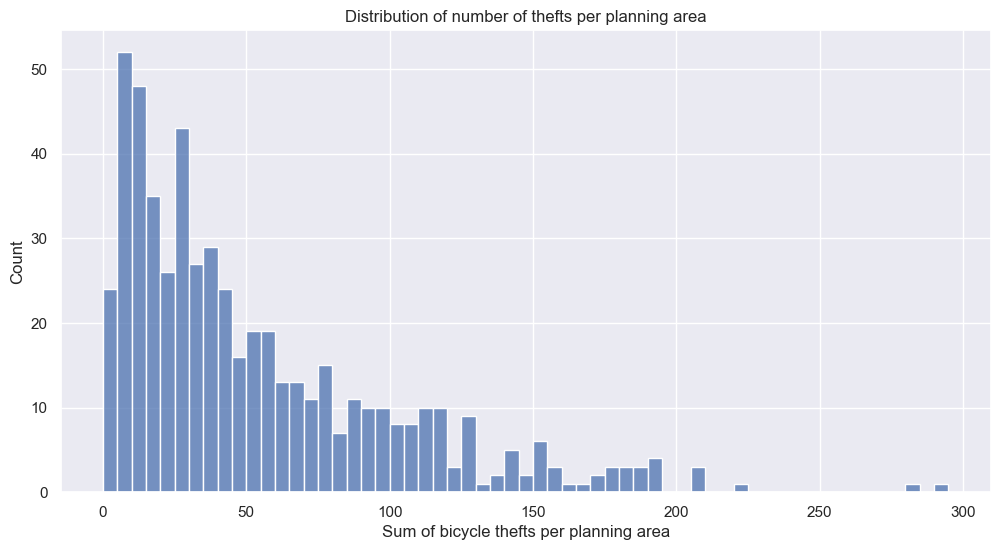

In [112]:
# visualise distribution of sum(thefts) per Planungsraum
g = sns.histplot(data=lor, x='Diebstaehle', binwidth=5)
g.set_xlabel("Sum of bicycle thefts per planning area")
g.set_title("Distribution of number of thefts per planning area")
plt.show()

We can see that the amount of bicycle thefts per planning area is very low for the most areas with the mode at 7, which is quite nice. As the number of thefts is increasing the amount of places where so many thefts are taking place is decreasing. This seems very intuitive.

In [ ]:
# visualise theft per Planungsraum as choropleth
bins = [0, *[np.quantile(lor.Diebstaehle, x) for x in [0.2, 0.4, 0.6, 0.8, 0.95]], np.max(lor.Diebstaehle)+1]
lor['Thefts range'] = pd.cut(lor.Diebstaehle, bins, right=False)
colors = ['#fee5d9','#fcbba1','#fc9272','#fb6a4a','#de2d26','#a50f15']

fig = px.choropleth(
    lor.sort_values(by='Diebstaehle'),
    geojson=geojson,
    color="Thefts range",
    color_discrete_sequence=colors,
    locations="Planungsraum (Nummer)",
    featureidkey="properties.PLR_ID",
    projection="mercator",
    hover_data={"Planungsraum (Name)":True, "Diebstaehle":True, "Planungsraum (Nummer)":False},
    width=800,
    height=600,
)
fig.update_geos(fitbounds="locations", visible=False)
fig.update_layout(margin={"r": 0, "t": 0, "l": 0, "b": 0})
print("Bicycle thefts in Berlin per planning area")
fig.show()

hotspots in center of berlin

### Total damage amount?

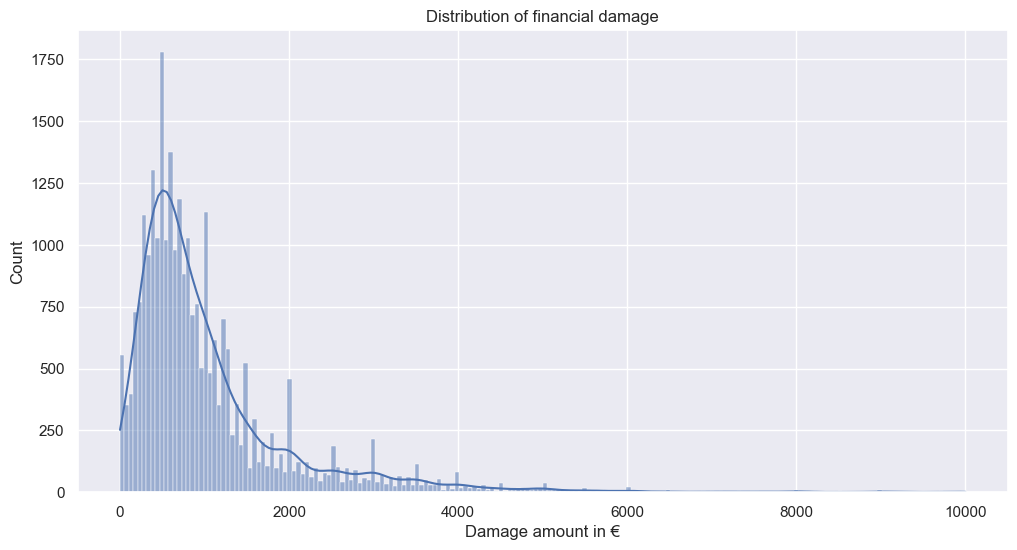

In [111]:
# visualise distribution of Schadenshöhe
# SCHADENSHOEHE = Wert des erlangten Gutes (in Euro), kein Sachschaden! Summenangabe, bei mehr als einem entwendetem Fahrrad.
# Bei Kellereinbrüchen weist die Schadenshöhe in Summe nicht nur der Wert der gestohlenen Fahrräder aus, sondern inkludiert auch den Wert weiterer entwendeter Gegenstände.
g = sns.histplot(df[df['DELIKT'] == 'Fahrraddiebstahl']['SCHADENSHOEHE'], kde=True)
g.set_xlabel("Damage amount in €")
g.set_title("Distribution of financial damage")
plt.show()

The total damage per area is more or less symetrically distributed around ~500, although it is incredibly heavy-tailed at the right side which indicates that there are some places with huge total damage amounts, but that these do not appear very often. So one could argue that while most places don't deal with big amounts of damages, some isolated places are doomed with far higher damages. The damage amount concentrates in some areas.

In [56]:
# sum up Schadenshöhe without "Kellereinbrüchen"
df[df['DELIKT'] == 'Fahrraddiebstahl']['SCHADENSHOEHE'].sum()

28944420

### What time of the year? Seasonal trends?

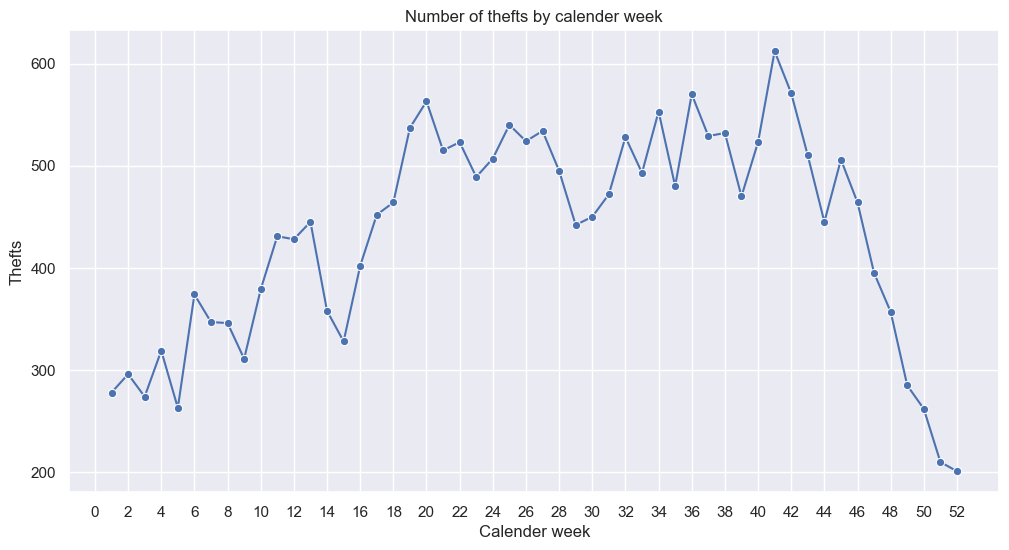

In [107]:
# just look at the data of a full year (2022)
df_22 = df[df['TATZEIT_ENDE'].dt.year == 2022]

# visualize thefts per calender week
count_per_kw = (
    df.groupby(by=df_22["TATZEIT_ANFANG"].dt.isocalendar().week)
    .size()
    .to_frame()
    .rename(columns={0: "Diebstaehle"})
)

count_per_kw.index = count_per_kw.index.astype(int)
g = sns.lineplot(count_per_kw, markers=True)
g.set_xlabel("Calender week")
g.set_ylabel("Thefts")
g.set_xticks(range(0,53,2))
g.set_title("Number of thefts by calender week")
plt.legend([],[], frameon=False)
plt.show()

As we can see, the amount of thefts are quite low in winter and start to rise until may (with some natural fluctation). It stays at amount of may until mid october when it drops tremendously when winter begins. This seems very reasonable, since in winter there are not many people who use their bicycle and probabely store them safely in their homes while also the demand for bicycles will be quite low in winter. Not though that there are still some bikes stolen in winter, so watch out where you store it safely!

### What daytime?

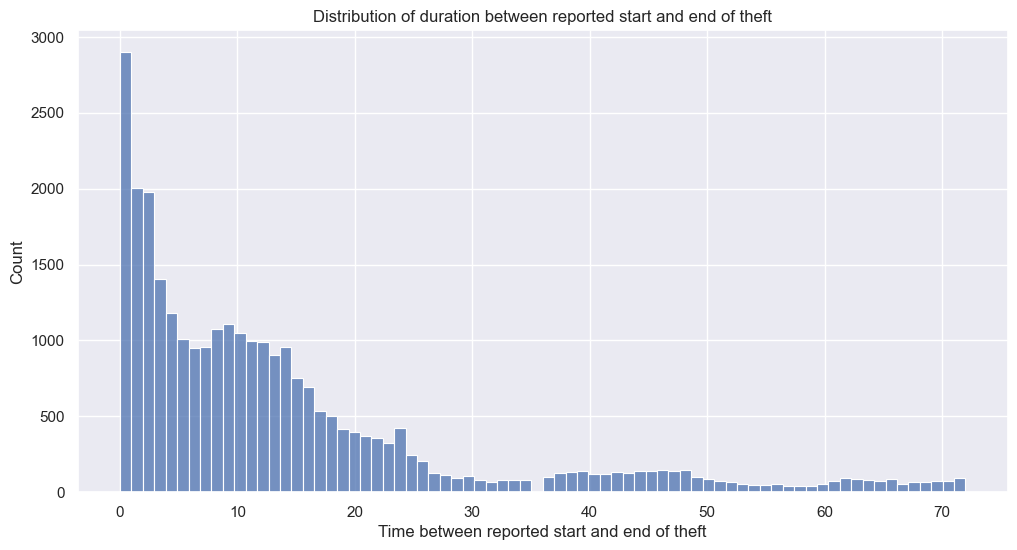

In [108]:
# visualise distribution of time between TATZEIT_ANFANG and TATZEIT_ENDE
g = sns.histplot((df["TATZEIT_ENDE"] - df["TATZEIT_ANFANG"]) / pd.Timedelta("1 hour"))
g.set_xlabel("Time between reported start and end of theft")
g.set_title("Distribution of duration between reported start and end of theft")
plt.show()

In this plot we can see the time frame victims reported in which their bike got stolen. We see the mode around 0-1 and that the empirical probability declines with the raising amount of the time frame. No big surprises here. But what we can gain is that most bikes got stolen in a short period of time, so one has to be always cautios where to park his or her bike even when only doing a stop for an hour for example!

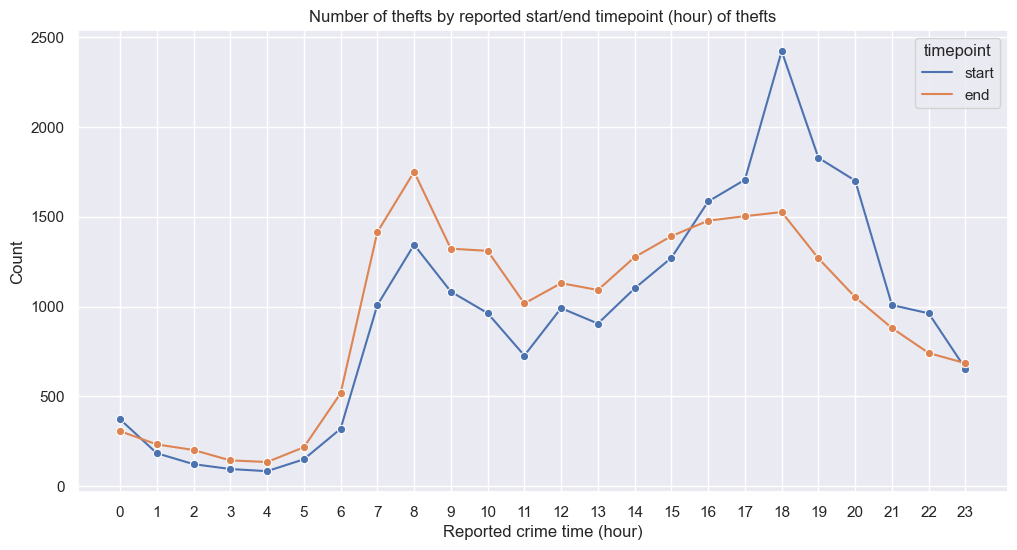

In [109]:
# visualize thefts per TATZEIT HOUR
count_per_hour_START = (
    df.groupby(by=df_22["TATZEIT_ANFANG"].dt.hour)
    .size()
    .to_frame()
    .rename(columns={0: "Diebstaehle"})
)

count_per_hour_END = (
    df.groupby(by=df_22["TATZEIT_ENDE"].dt.hour)
    .size()
    .to_frame()
    .rename(columns={0: "Diebstaehle"})
)

count_per_hour = pd.concat((count_per_hour_START, count_per_hour_END)).reset_index(names='hour')
count_per_hour['timepoint'] = 'end'
count_per_hour.iloc[0:24, 2] = 'start'
count_per_hour['hour'] = count_per_hour['hour'].astype(int)

g = sns.lineplot(data=count_per_hour, x='hour', y='Diebstaehle', hue='timepoint', marker="o")
g.set_xlabel("Reported crime time (hour)")
g.set_ylabel("Count")
g.set_xticks(range(0,24))
g.set_title("Number of thefts by reported start/end timepoint (hour) of thefts")
plt.show()


START
By far most crimes start to take place around 18 and 19 o'clock. There is another mode around 8 in the morning. One might check the end time of the crime below though!

END
As one might suspect a lot of people recocgnize in the morning that their bike got stolen, which aligns with the suspicion that most of the bikes get stolen during the night. Especially in big cities like Berlin, where criminal groups use professional tools, big trucks and the cover of the dark night to take action. Maybe one rule we could gain is: if possible, try to get your bike inside the house/in the basement at night!